In [13]:
%matplotlib inline
import pandas as pd
import xarray as xr
import nivapy3 as nivapy
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import watexr_utils as wx

plt.style.use('ggplot')

# Comparing ERA-5 data to observed datasets from met.no

In [2]:
# Read merged data
ds = xr.open_dataset(r'/home/jovyan/shared/WATExR/ERA5/morsa_era5_merged.nc')
ds

<xarray.Dataset>
Dimensions:    (latitude: 3, longitude: 2, time: 350640)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 ... 2019-12-31T23:00:00
  * longitude  (longitude) float32 10.68 10.93
  * latitude   (latitude) float32 59.84 59.59 59.34
Data variables:
    uas        (time, latitude, longitude) float32 ...
    vas        (time, latitude, longitude) float32 ...
    tdps       (time, latitude, longitude) float32 ...
    tas        (time, latitude, longitude) float32 ...
    slp??      (time, latitude, longitude) float32 ...
    rsds       (time, latitude, longitude) float32 ...
    rlds       (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-16 14:34:44 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

In [3]:
# Print variable info
for var in ds.variables:
    print(var)
    print('    ', ds[var].attrs)

time
     {'long_name': 'time'}
longitude
     {'units': 'degrees_east', 'long_name': 'longitude'}
latitude
     {'units': 'degrees_north', 'long_name': 'latitude'}
uas
     {'units': 'm s**-1', 'long_name': '10 metre U wind component'}
vas
     {'units': 'm s**-1', 'long_name': '10 metre V wind component'}
tdps
     {'units': 'K', 'long_name': '2 metre dewpoint temperature'}
tas
     {'units': 'K', 'long_name': '2 metre temperature'}
slp??
     {'units': 'Pa', 'long_name': 'Surface pressure', 'standard_name': 'surface_air_pressure'}
rsds
     {'units': 'J m**-2', 'long_name': 'Surface solar radiation downwards', 'standard_name': 'surface_downwelling_shortwave_flux_in_air'}
rlds
     {'units': 'J m**-2', 'long_name': 'Surface thermal radiation downwards'}
tcc
     {'units': '(0 - 1)', 'long_name': 'Total cloud cover', 'standard_name': 'cloud_area_fraction'}
tp
     {'units': 'm', 'long_name': 'Total precipitation'}


## 2. Processing of ERA-5 data

In [4]:
# Variables for comparison to met.no's observational dataset
var_list = ['tp', 'tas']

# Extract data
ds = ds[var_list]

# Spatial average
ds = ds.mean(dim=['latitude', 'longitude'])

# Convert units
ds['tp'] = ds['tp']*1000         # m to mm
ds['tas'] = ds['tas'] - 273.15   # K to C

era_df = ds.to_dataframe()

# Hourly to daily
era_df = era_df.resample('D').agg({'tp':'sum',
                                   'tas':'mean'})

era_df.head()

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


,tp,tas
time,,
1980-01-01,0.955328,-3.431333
1980-01-02,0.000191,-9.769214
1980-01-03,0.000717,-16.038000
1980-01-04,0.171992,-17.430201
1980-01-05,6.785640,-7.284504


## 3. Processing of observed data from met.no

In [14]:
# Read observations
obs_df = pd.read_csv(r'../../Data/Meteorological/Obs_metno/Obs_Metno_1km_gridded_Morsa_v2.csv')
obs_df['Date'] = pd.to_datetime(obs_df['Date'], format='%d/%m/%Y %H:%M')
obs_df.set_index('Date', inplace=True)
obs_df = obs_df[['TG_catch', 'RR_catch']]
obs_df = obs_df.resample('D').agg({'TG_catch':'mean',
                                   'RR_catch':'sum'})
obs_df.head()

,TG_catch,RR_catch
Date,,
1970-12-31,-9.243695,0.000000
1971-01-01,-10.881015,0.000000
1971-01-02,-9.843024,0.000000
1971-01-03,-2.851721,0.000000
1971-01-04,-2.219738,0.000096


## 4. Compare datasets

In [6]:
# Join data
df = era_df.join(obs_df).dropna(how='any')

# Extract temp and ppt
temp_df = df[['tas', 'TG_catch']]
pptn_df = df[['tp', 'RR_catch']]

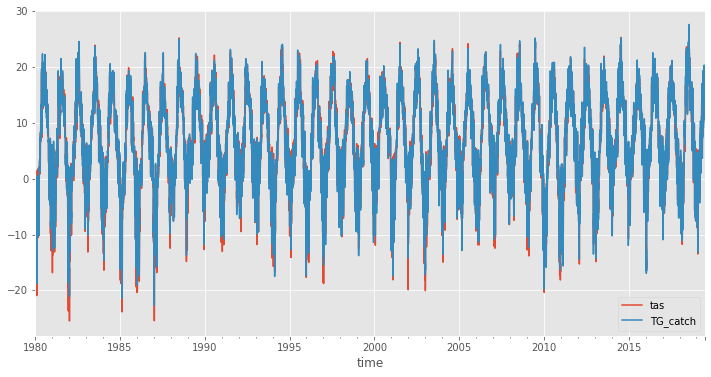

In [8]:
temp_df.plot(figsize=(12, 6))

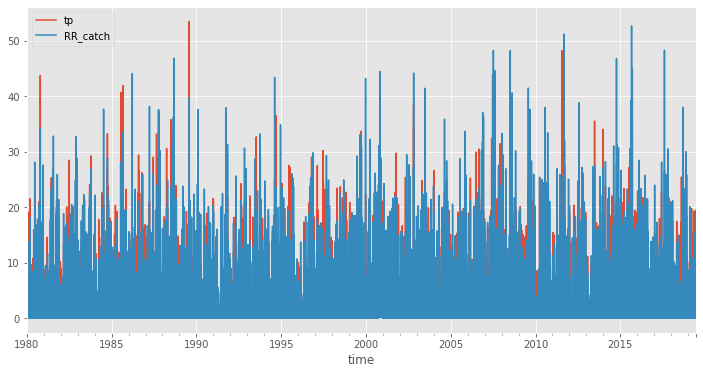

In [9]:
pptn_df.plot(figsize=(12, 6))

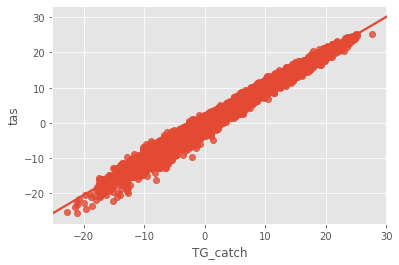

In [10]:
sn.regplot(x='TG_catch', y='tas', data=df)

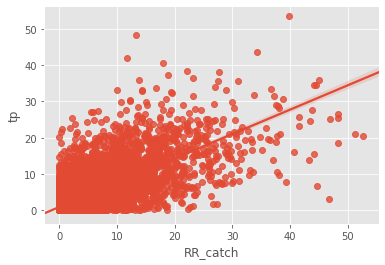

In [11]:
sn.regplot(x='RR_catch', y='tp', data=df)

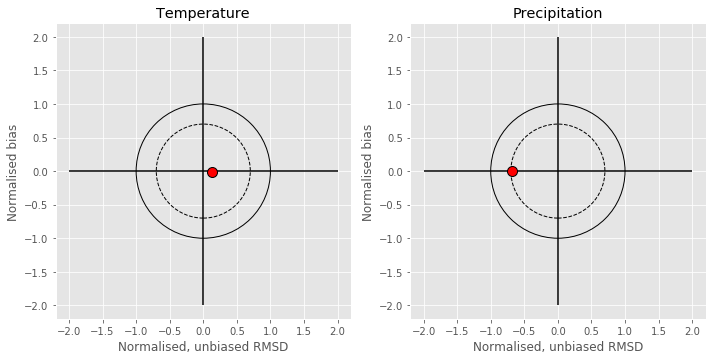

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 15), subplot_kw={'aspect':'equal'})
wx.target_plot(df['tas'], df['TG_catch'], ax=axes[0], title='Temperature')
wx.target_plot(df['tp'], df['RR_catch'], ax=axes[1], title='Precipitation')
plt.tight_layout()